<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/Kurs_classic_DAF_SI_regress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных:

In [ ]:
!pip install catboost -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.1 MB/s eta 0:00:00


In [ ]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error, make_scorer

# Регрессия с трансформацией цели
from sklearn.compose import TransformedTargetRegressor

from pickle import TRUE
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import joblib

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade_df = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['CC50', 'IC50'])
pca_cleaned_SI = pd.read_csv(os.path.join(data_dir,'pca_cleaned_SI.csv'))
tsne_cleaned_SI = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_SI.csv'))
umap_cleaned_SI = pd.read_csv(os.path.join(data_dir,'umap_cleaned_SI.csv'))

In [ ]:
# @title Подготовка данных для моделирования
analyse_name = 'regres'
base_parameter = 'SI'

# подготовка данных для handmade_df
metod_name_1 = 'df_handmade'
X1 = handmade_df.drop(columns=[base_parameter])
y1 = handmade_df[base_parameter]
base_name1 = f"{base_parameter}_{analyse_name}_{metod_name_1}"
csv_file_1 = f"results_{base_name1}.csv"
comparison_file_1 = f"comparison_{base_name1}_"
model_file_1 = f"model_{base_name1}_"

# подготовка данных для pca
metod_name_2 = 'pca'
X2 = pca_cleaned_SI.drop(columns=[base_parameter])
y2 = pca_cleaned_SI[base_parameter]
base_name2 = f"{base_parameter}_{analyse_name}_{metod_name_2}"
csv_file_2 = f"results_{base_name2}.csv"
comparison_file_2 = f"comparison_{base_name2}_"
model_file_2 = f"model_{base_name2}_"

# подготовка данных для tsne
metod_name_3 = 'tsne'
X3 = tsne_cleaned_SI.drop(columns=[base_parameter])
y3 = tsne_cleaned_SI[base_parameter]
base_name3 = f"{base_parameter}_{analyse_name}_{metod_name_3}"
csv_file_3 = f"results_{base_name3}.csv"
comparison_file_3 = f"comparison_{base_name3}_"
model_file_3 = f"model_{base_name3}_"

# подготовка данных для umap
metod_name_4 = 'umap'
X4 = umap_cleaned_SI.drop(columns=[base_parameter])
y4 = umap_cleaned_SI[base_parameter]
base_name4 = f"{base_parameter}_{analyse_name}_{metod_name_4}"
csv_file_4 = f"results_{base_name4}.csv"
comparison_file_4 = f"comparison_{base_name4}_"
model_file_4 = f"model_{base_name4}_"

# название файла с хранением всех результатов
csv_file_final = f"{analyse_name}_{base_parameter}.csv"

# МОДЕЛИРОВАНИЕ

In [ ]:
# @title класс RegressionModelEvaluator для анализа моделей регрессии
class RegressionModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42,
                 log_target=False, models_config=None, metod_name=""):
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.log_target = log_target
        self.models = {}
        self.results = None
        self.best_model = None
        self.metod_name = metod_name

        # проверка данных
        if log_target and (self.y <= 0).any():
            raise ValueError("все значения y должны быть положительными")

        # логарифмирование целевой переменной
        epsilon = 1e-8
        self.y_transformed = np.log1p(self.y + epsilon) if log_target else self.y

        # разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y_transformed,
            test_size=test_size,
            random_state=random_state
        )

        # инициализация моделей
        if models_config is None:
            self.models = create_models_config(random_state)
        else:
            self.models = models_config

    def create_models_config(random_state=42):
        models_config = {
            # Линейные модели с регуляризацией: Ridge, Lasso, ElasticNet
            'Ridge': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Ridge()
                ),
                'params': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
            },
            'Lasso': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Lasso()
                ),
                'params': {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
            },
            'ElasticNet': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    ElasticNet()
                ),
                'params': {
                    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1],
                    'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
                }
            },
            # Метод опорных векторов (SVR)
            'SVR': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVR()
                ),
                'params': {
                    'svr__kernel': ['linear', 'rbf', 'poly'],
                    'svr__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'svr__epsilon': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
                }
            },
            # Метод k-ближайших соседей (KNN)
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsRegressor()
                ),
                'params': {
                    'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kneighborsregressor__weights': ['uniform', 'distance'],
                    'kneighborsregressor__p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
                }
            },
            # модели деревьев
            'DecisionTree': {
                'model': DecisionTreeRegressor(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5]
                }
            },
            'RandomForest': {
                'model': RandomForestRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5],
                    'max_features': ['sqrt', 0.8]
                }
            },
            # Бустеры
            'GradientBoosting': {
                'model': GradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [None, 5, 10],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostRegressor(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            },
            # МОДЕЛИ ДЛЯ ГАММА-РАСПРЕДЕЛЕНИЯ
            #'GLM_Gamma': {
            #    'model': make_pipeline(
            #        StandardScaler(),
            #        TweedieRegressor(power=2, link='log', max_iter=1000)
            #    ),
            #   'params': {
            #       'tweedieregressor__alpha': [0.001, 0.01, 0.1, 1],
            #       'tweedieregressor__max_iter': [1000]
            #   }
            #},
            'XGBoost_Tweedie': {
                'model': XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.9, random_state=self.random_state),
                'params': {
                    'n_estimators': [200, 300],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost_Tweedie': {
                'model': CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [200, 300],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            }
        }
        return models_config


    def evaluate_models(self):
        results = []

        # функция для RMSE
        def rmse(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))

        # make_scorer на основе RMSE
        rmse_scorer = make_scorer(rmse, greater_is_better=False)

        # перебираем модели и гиперпараметры
        for name, model_info in self.models.items():
            model = model_info['model']
            params = model_info['params']

            # подбор параметров через гридсерч
            gs = GridSearchCV(
                model,
                params,
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            gs.fit(self.X_train, self.y_train)

            # лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = -gs.best_score_

            # предсказания
            y_pred = best_model.predict(self.X_test)

            # метрики
            metrics = {
                'Model': name,
                'Metod': self.metod_name,
                'Best Parameters': best_params,
                'CV MSE': cv_score,
                'Test MSE': mean_squared_error(self.y_test, y_pred),
                'Test RMSE': rmse(self.y_test, y_pred),
                'Test MAE': mean_absolute_error(self.y_test, y_pred),
                'Test R2': r2_score(self.y_test, y_pred),
                'Test Explained Variance': explained_variance_score(self.y_test, y_pred),
                'Test Max Error': max_error(self.y_test, y_pred),
                'Test MAPE': mean_absolute_percentage_error(self.y_test, y_pred),
                'Log Target': self.log_target,
                'Model Object': best_model  # сохраняем саму модель для последующего использования
            }

            results.append(metrics)
            print(f"{name} Test MSE: {metrics['Test MSE']:.3f}")

            # сохраняем лучшую модель
            if self.best_model is None or metrics['Test MSE'] < self.best_model[1]:
                self.best_model = (best_model, metrics['Test MSE'])

        # сохраняем результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test MSE')

        return self.results

    def get_top_models(self, n=3):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        top_models = []
        for model_name in self.results.index[:n]:
            model_info = {
                'name': model_name,
                'model': self.results.loc[model_name, 'Model Object'],
                'metrics': self.results.loc[model_name].to_dict()
            }
            top_models.append(model_info)

        return top_models

    def save_top_models(self, n=3, prefix='model_',
                       data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        os.makedirs(data_dir, exist_ok=True)
        top_models = self.get_top_models(n)

        # сохраняем модели
        saved_files = []
        for model_info in top_models:
            filename = f"{prefix}{model_info['name'].lower().replace(' ', '_')}.pkl"
            filepath = os.path.join(data_dir, filename)

            joblib.dump(model_info['model'], filepath)
            saved_files.append(filepath)
            print(f"Модель {model_info['name']} сохранена в {filepath}")

        # сохраняем метрики
        metrics_filename = f"{prefix}top_{n}_models_metrics.csv"
        metrics_filepath = os.path.join(data_dir, metrics_filename)

        # создаем DataFrame с метриками
        metrics_data = []
        for model_info in top_models:
            metrics = model_info['metrics']
            metrics.pop('Model Object', None)
            metrics.pop('Best Parameters', None)
            metrics_data.append(metrics)

        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_csv(metrics_filepath, index=False)
        print(f"Метрики топ-{n} моделей сохранены в {metrics_filepath}")

        return {
            'model_files': saved_files,
            'metrics_file': metrics_filepath
        }

    def predict(self, X, inverse_transform=False):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        preds = self.best_model[0].predict(X)

        if self.log_target and inverse_transform:
            return np.expm1(preds)
        return preds


    def save_model(self, model_name=None, filename='model.pkl',
                  data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        if not hasattr(self, 'results'):
            raise ValueError("Сначала выполните evaluate_models()")
        filepath = os.path.join(data_dir, filename)
        os.makedirs(data_dir, exist_ok=True)
        if model_name is None:
            model = self.best_model[0]
            print(f"Лучшая модель ({model.__class__.__name__}) сохранена в {filepath}")
        else:
            if model_name not in self.results.index:
                raise ValueError(f"Модель {model_name} не найдена. Доступные модели: {list(self.results.index)}")
            best_params = self.results.loc[model_name, 'Best Parameters']
            model = self.models[model_name]['model'].set_params(**best_params)
            model.fit(self.X_train, self.y_train)
            print(f"Модель {model_name} сохранена в {filepath}")

        joblib.dump(model, filepath)

    def compare_top_models_predictions(self, n=3, plot=True, figsize=(15, 10)):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")
        top_models = self.get_top_models(n)
        # Dataаrame для сравнения
        comparison_df = pd.DataFrame({
            'Actual': self.y if not self.log_target else np.expm1(self.y_transformed)
        })
        # предсказания каждой модели
        for model_info in top_models:
            model_name = model_info['name']
            model = model_info['model']

            # предсказания (с обратным преобразованием если нужно)
            preds = model.predict(self.X)
            if self.log_target:
                preds = np.expm1(preds)

            comparison_df[f'Predicted_{model_name}'] = preds

        if plot:
            plt.figure(figsize=figsize)
            # график фактических и предсказанных значений
            for i, model_info in enumerate(top_models, 1):
                model_name = model_info['name']
                plt.subplot(2, 2, i)
                sns.scatterplot(x='Actual', y=f'Predicted_{model_name}', data=comparison_df)
                plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()],
                         [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
                         'r--')
                plt.title(f'Actual vs Predicted ({model_name})')
                plt.xlabel('Actual Values')
                plt.ylabel('Predicted Values')

            # график распределения ошибок
            plt.subplot(2, 2, 4)
            for model_info in top_models:
                model_name = model_info['name']
                errors = comparison_df['Actual'] - comparison_df[f'Predicted_{model_name}']
                sns.kdeplot(errors, label=model_name)
            plt.title('Distribution of Prediction Errors')
            plt.xlabel('Prediction Error')
            plt.legend()

            plt.tight_layout()
            plt.show()

        # расчет метрик ошибок
        metrics_comparison = []
        for model_info in top_models:
            model_name = model_info['name']
            actual = comparison_df['Actual']
            predicted = comparison_df[f'Predicted_{model_name}']

            metrics = {
                'Model': model_name,
                'Full Dataset MSE': mean_squared_error(actual, predicted),
                'Full Dataset RMSE': np.sqrt(mean_squared_error(actual, predicted)),
                'Full Dataset MAE': mean_absolute_error(actual, predicted),
                'Full Dataset R2': r2_score(actual, predicted),
                'Full Dataset MAPE': mean_absolute_percentage_error(actual, predicted)
            }
            metrics_comparison.append(metrics)

        metrics_df = pd.DataFrame(metrics_comparison).set_index('Model')

        return comparison_df, metrics_df

    def save_comparison_results(self, n=3, prefix='comparison_',
                              data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        os.makedirs(data_dir, exist_ok=True)
        comparison_df, metrics_df = self.compare_top_models_predictions(n, plot=False)

        # сохраняем предсказания
        predictions_filename = f"{prefix}top_{n}_predictions.csv"
        predictions_filepath = os.path.join(data_dir, predictions_filename)
        comparison_df.to_csv(predictions_filepath, index=False)
        print(f"Предсказания топ-{n} моделей сохранены в {predictions_filepath}")

        # сохраняем метрики
        metrics_filename = f"{prefix}top_{n}_full_metrics.csv"
        metrics_filepath = os.path.join(data_dir, metrics_filename)
        metrics_df.to_csv(metrics_filepath)
        print(f"Метрики топ-{n} моделей на всем датасете сохранены в {metrics_filepath}")

        # сохраняем графики
        self.compare_top_models_predictions(n, plot=True)
        plot_filename = f"{prefix}top_{n}_comparison_plot.png"
        plot_filepath = os.path.join(data_dir, plot_filename)
        plt.savefig(plot_filepath, bbox_inches='tight')
        plt.close()
        print(f"Графики сравнения сохранены в {plot_filepath}")

        return {
            'predictions_file': predictions_filepath,
            'metrics_file': metrics_filepath,
            'plot_file': plot_filepath
        }

In [ ]:
# @title Функция визуализации
def plot_prediction_comparison(x, y):
    # Вычисление ошибок предсказания
    errors = x - y

    plt.figure(figsize=(20, 5))

    # График рассеяния
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=x, y=y, alpha=0.5, label='Предсказанные vs Реальные')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Идеальная линия')
    plt.xlabel('Реальные значения IC50')
    plt.ylabel('Предсказанные значения IC50')
    plt.title('Сравнение предсказанных и реальных значений IC50')
    plt.legend()
    plt.tight_layout()

    # Гистограмма ошибок
    plt.subplot(1, 2, 2)
    sns.histplot(errors, bins=30, kde=True, color='purple', alpha=0.6)
    plt.title('Гистограмма ошибок предсказания')
    plt.xlabel('Ошибка предсказания (Реальное - Предсказанное)')
    plt.ylabel('Частота')

    plt.show()

Ridge Test MSE: 1.595
Lasso Test MSE: 1.177
ElasticNet Test MSE: 0.987
SVR Test MSE: 0.968
KNN Test MSE: 0.977
DecisionTree Test MSE: 1.295
ExtraTrees Test MSE: 0.806
RandomForest Test MSE: 0.823
GradientBoosting Test MSE: 0.866
HistGradientBoosting Test MSE: 0.900
XGBoost Test MSE: 0.837
CatBoost Test MSE: 0.835
XGBoost_Tweedie Test MSE: 0.853
CatBoost_Tweedie Test MSE: 0.902
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_df_handmade_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_df_handmade_top_3_full_metrics.csv


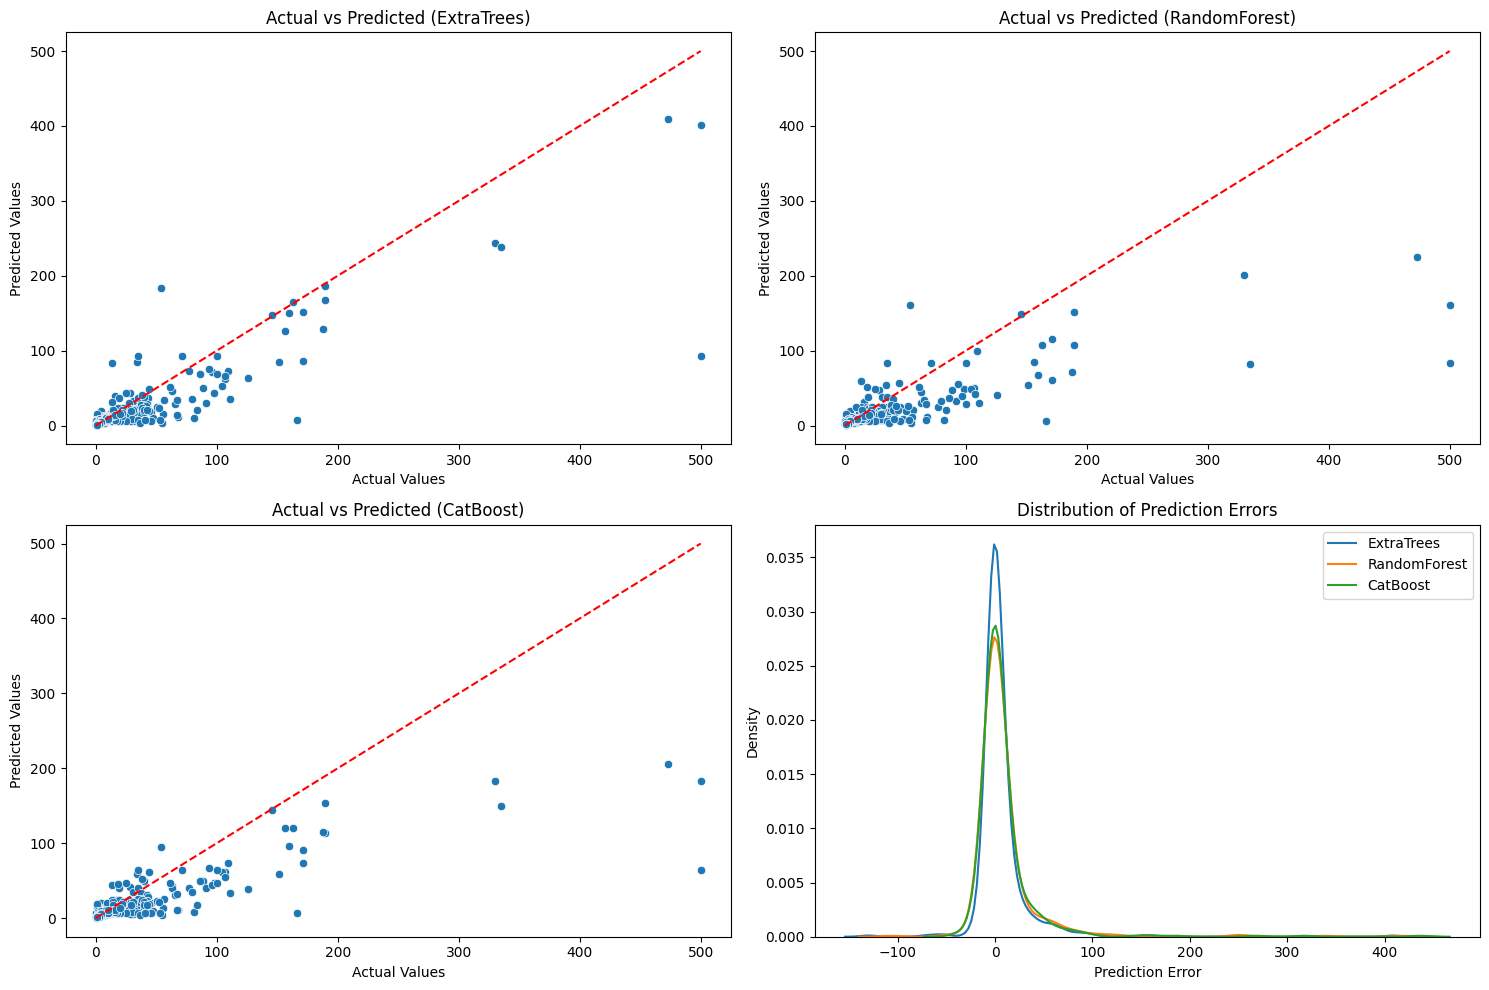

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_df_handmade_top_3_comparison_plot.png
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_df_handmade_extratrees.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_df_handmade_randomforest.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_df_handmade_catboost.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_df_handmade_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_df_handmade_extratrees.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_df_handmade_randomforest.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_df_handmade_catboost.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_df_handmade_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на руяных данных
# инициализация
evaluator_handmade_df = RegressionModelEvaluator(X1, y1, log_target=True) # ПОМЕНЯТЬ ТУТ!

# оценка моделей
results = evaluator_handmade_df.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_handmade = results.copy()
results_handmade['metod'] = metod_name_1 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_handmade_df = results_handmade[columns_order]

# предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_handmade_df.predict(X1, inverse_transform=True) # ПОМЕНЯТЬ ТУТ!
predictions_handmade_df = predictions

# сохраненние общего результата
results_handmade_df_id = results_handmade_df.reset_index()
results_handmade_df_id.to_csv(os.path.join(data_dir, csv_file_1), index=False) # ПОМЕНЯТЬ ТУТ!

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_handmade_df.save_comparison_results(n=3, prefix=comparison_file_1, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_handmade_df.save_top_models(n=3, prefix=model_file_1 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_handmade_df.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
ExtraTrees,df_handmade,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",1.356914,0.805513,0.897503,0.722676,0.313662,0.315341,2.060352,0.403289,True,"(ExtraTreeRegressor(max_depth=10, random_state..."
RandomForest,df_handmade,"{'max_depth': 10, 'max_features': 0.8, 'min_sa...",1.328094,0.822708,0.907032,0.729020,0.299011,0.299768,2.326744,0.414137,True,"(DecisionTreeRegressor(max_depth=10, max_featu..."
CatBoost,df_handmade,"{'depth': 7, 'iterations': 300, 'l2_leaf_reg':...",1.338206,0.834861,0.913707,0.729315,0.288656,0.288959,2.292730,0.415932,True,<catboost.core.CatBoostRegressor object at 0x7...
XGBoost,df_handmade,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",1.321730,0.837296,0.915039,0.729029,0.286581,0.286672,2.558522,0.395478,True,"XGBRegressor(base_score=None, booster=None, ca..."
XGBoost_Tweedie,df_handmade,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",1.437154,0.853267,0.923725,0.713098,0.272973,0.297005,2.176927,0.386863,True,"XGBRegressor(base_score=None, booster=None, ca..."


Ridge Test MSE: 1.499
Lasso Test MSE: 1.176
ElasticNet Test MSE: 1.125
SVR Test MSE: 1.015
KNN Test MSE: 1.046
DecisionTree Test MSE: 1.229
ExtraTrees Test MSE: 0.954
RandomForest Test MSE: 0.920
GradientBoosting Test MSE: 0.974
HistGradientBoosting Test MSE: 1.014
XGBoost Test MSE: 1.001
CatBoost Test MSE: 0.950
XGBoost_Tweedie Test MSE: 1.141
CatBoost_Tweedie Test MSE: 1.051
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_pca_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_pca_top_3_full_metrics.csv


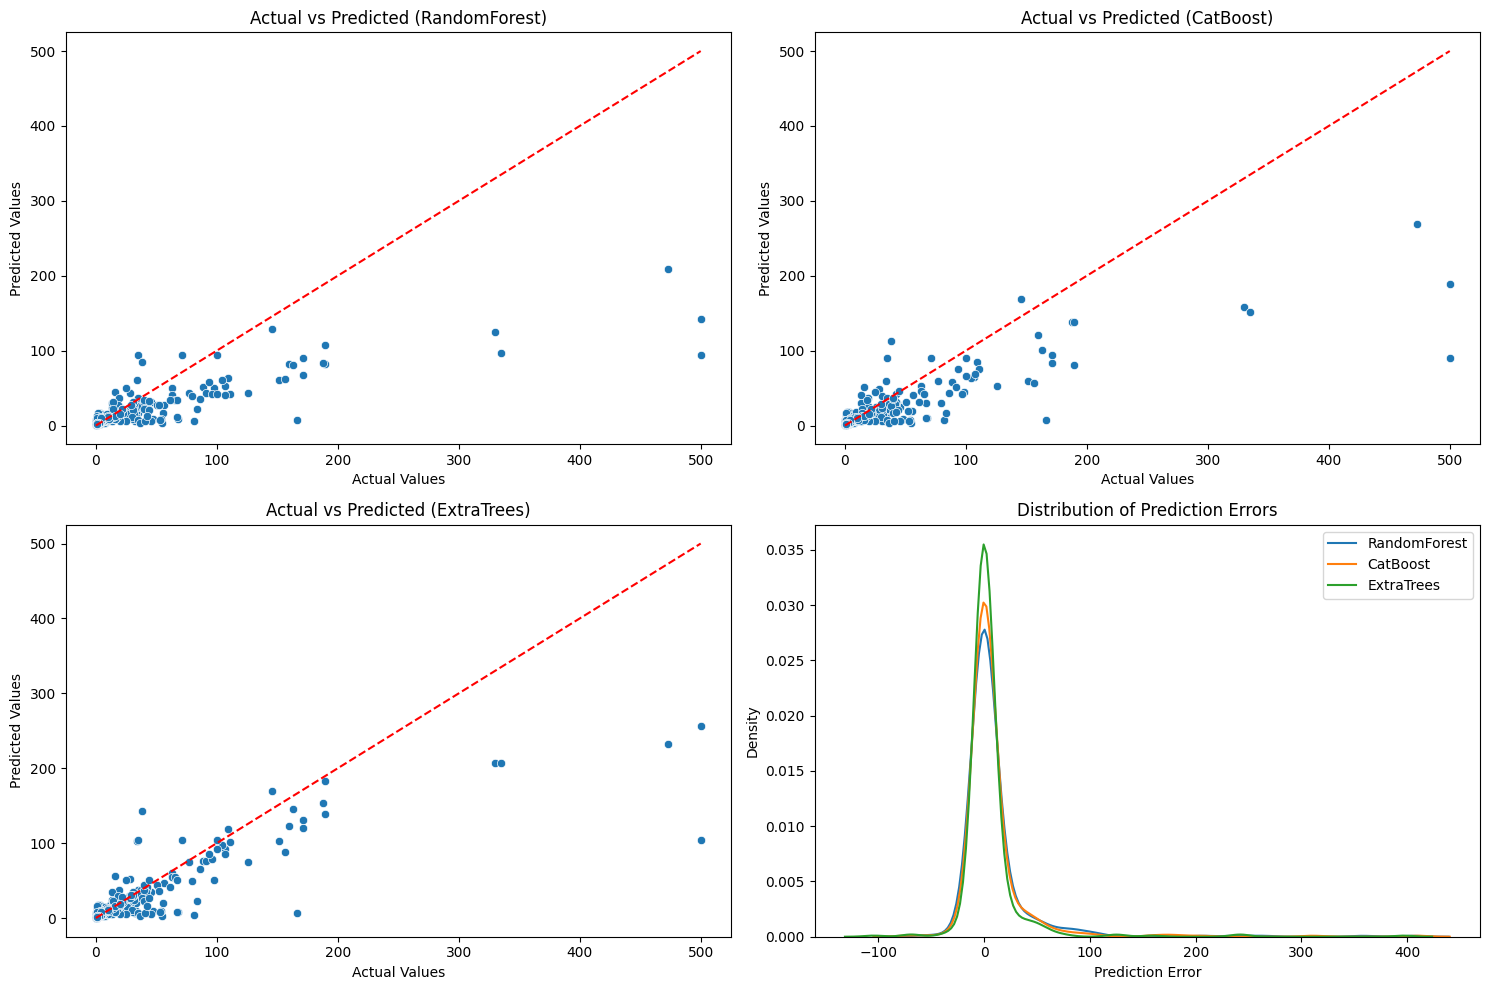

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_pca_top_3_comparison_plot.png
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_pca_randomforest.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_pca_catboost.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_pca_extratrees.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_pca_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_pca_randomforest.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_pca_catboost.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_pca_extratrees.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_pca_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных PCA(50 параметров)
# Инициализация
evaluator_pca = RegressionModelEvaluator(X2, y2, log_target=True)

# Оценка моделей
results = evaluator_pca.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_pca = results.copy()
results_pca['metod'] = metod_name_2 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_pca = results_pca[columns_order]

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_pca.predict(X2, inverse_transform=True)
predictions_pca = predictions

# Сохраненние результата
results_pca_id = results_pca.reset_index()
results_pca_id.to_csv(os.path.join(data_dir, csv_file_2), index=False)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_pca.save_comparison_results(n=3, prefix=comparison_file_2, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_pca.save_top_models(n=3, prefix=model_file_2 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_pca.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
RandomForest,pca,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",1.353654,0.920129,0.959234,0.779385,0.216003,0.221006,2.493305,0.460627,True,"(DecisionTreeRegressor(max_depth=20, max_featu..."
CatBoost,pca,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",1.331036,0.950148,0.974755,0.795352,0.190425,0.192389,2.223453,0.458402,True,<catboost.core.CatBoostRegressor object at 0x7...
ExtraTrees,pca,"{'max_depth': 30, 'min_samples_split': 5, 'n_e...",1.342978,0.954349,0.976908,0.788610,0.186846,0.189850,2.750187,0.449469,True,"(ExtraTreeRegressor(max_depth=30, min_samples_..."
GradientBoosting,pca,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",1.431860,0.973703,0.986764,0.807711,0.170356,0.172761,2.439870,0.473866,True,([DecisionTreeRegressor(criterion='friedman_ms...
XGBoost,pca,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",1.360342,1.001039,1.000519,0.797785,0.147064,0.155613,2.476466,0.470055,True,"XGBRegressor(base_score=None, booster=None, ca..."


Ridge Test MSE: 1.167
Lasso Test MSE: 1.176
ElasticNet Test MSE: 1.176
SVR Test MSE: 1.137
KNN Test MSE: 0.918
DecisionTree Test MSE: 1.601
ExtraTrees Test MSE: 0.977
RandomForest Test MSE: 1.051
GradientBoosting Test MSE: 1.343
HistGradientBoosting Test MSE: 1.069
XGBoost Test MSE: 1.244
CatBoost Test MSE: 0.988
XGBoost_Tweedie Test MSE: 1.168
CatBoost_Tweedie Test MSE: 1.025
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_tsne_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_tsne_top_3_full_metrics.csv


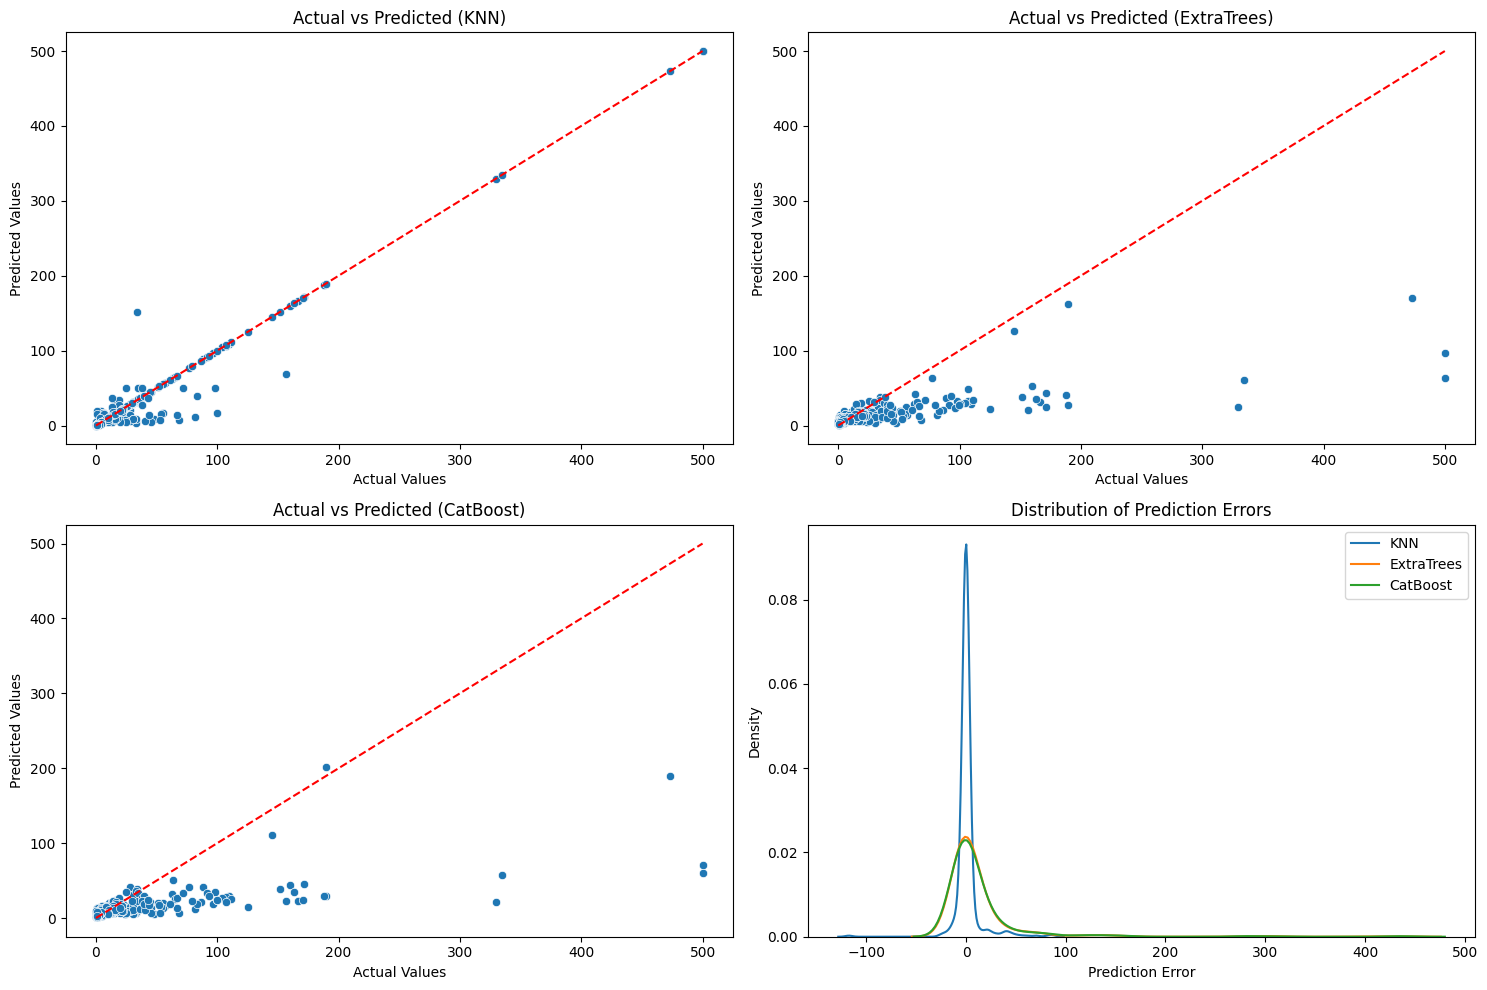

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_tsne_top_3_comparison_plot.png
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_tsne_knn.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_tsne_extratrees.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_tsne_catboost.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_tsne_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_tsne_knn.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_tsne_extratrees.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_tsne_catboost.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_tsne_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных tSME(3 параметра)
# Инициализация
evaluator_tsne = RegressionModelEvaluator(X3, y3, log_target=True)

# Оценка моделей
results = evaluator_tsne.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_tsne = results.copy()
results_tsne['metod'] = metod_name_3
columns_order = ['metod'] + [col for col in results.columns]
results_tsne = results_tsne[columns_order]


# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_tsne.predict(X3, inverse_transform=True)
predictions_tsne_cleaned = predictions

# Сохраненние результата
results_tsne_id = results_tsne.reset_index()
results_tsne_id.to_csv(os.path.join(data_dir, csv_file_3), index=False)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_tsne.save_comparison_results(n=3, prefix=comparison_file_3, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_tsne.save_top_models(n=3, prefix=model_file_3 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_tsne.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
KNN,tsne,"{'kneighborsregressor__n_neighbors': 8, 'kneig...",1.397922,0.918328,0.958294,0.783317,0.217538,0.217992,2.490108,0.429135,True,"(StandardScaler(), KNeighborsRegressor(n_neigh..."
ExtraTrees,tsne,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",1.430713,0.976514,0.988187,0.812101,0.167960,0.167996,2.339009,0.475253,True,"(ExtraTreeRegressor(max_depth=10, min_samples_..."
CatBoost,tsne,"{'depth': 7, 'iterations': 300, 'l2_leaf_reg':...",1.471522,0.988178,0.994071,0.827067,0.158022,0.158246,2.216624,0.485589,True,<catboost.core.CatBoostRegressor object at 0x7...
CatBoost_Tweedie,tsne,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",1.530548,1.024658,1.012254,0.823614,0.126939,0.144467,2.416850,0.443366,True,<catboost.core.CatBoostRegressor object at 0x7...
RandomForest,tsne,"{'max_depth': None, 'max_features': 'sqrt', 'm...",1.447041,1.050541,1.024959,0.837925,0.104885,0.106353,2.928474,0.499316,True,"(DecisionTreeRegressor(max_features='sqrt', ra..."


Ridge Test MSE: 1.182
Lasso Test MSE: 1.176
ElasticNet Test MSE: 1.176
SVR Test MSE: 1.117
KNN Test MSE: 0.919
DecisionTree Test MSE: 1.067
ExtraTrees Test MSE: 0.896
RandomForest Test MSE: 0.965
GradientBoosting Test MSE: 0.986
HistGradientBoosting Test MSE: 1.038
XGBoost Test MSE: 0.996
CatBoost Test MSE: 0.937
XGBoost_Tweedie Test MSE: 1.006
CatBoost_Tweedie Test MSE: 0.966
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_umap_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_umap_top_3_full_metrics.csv


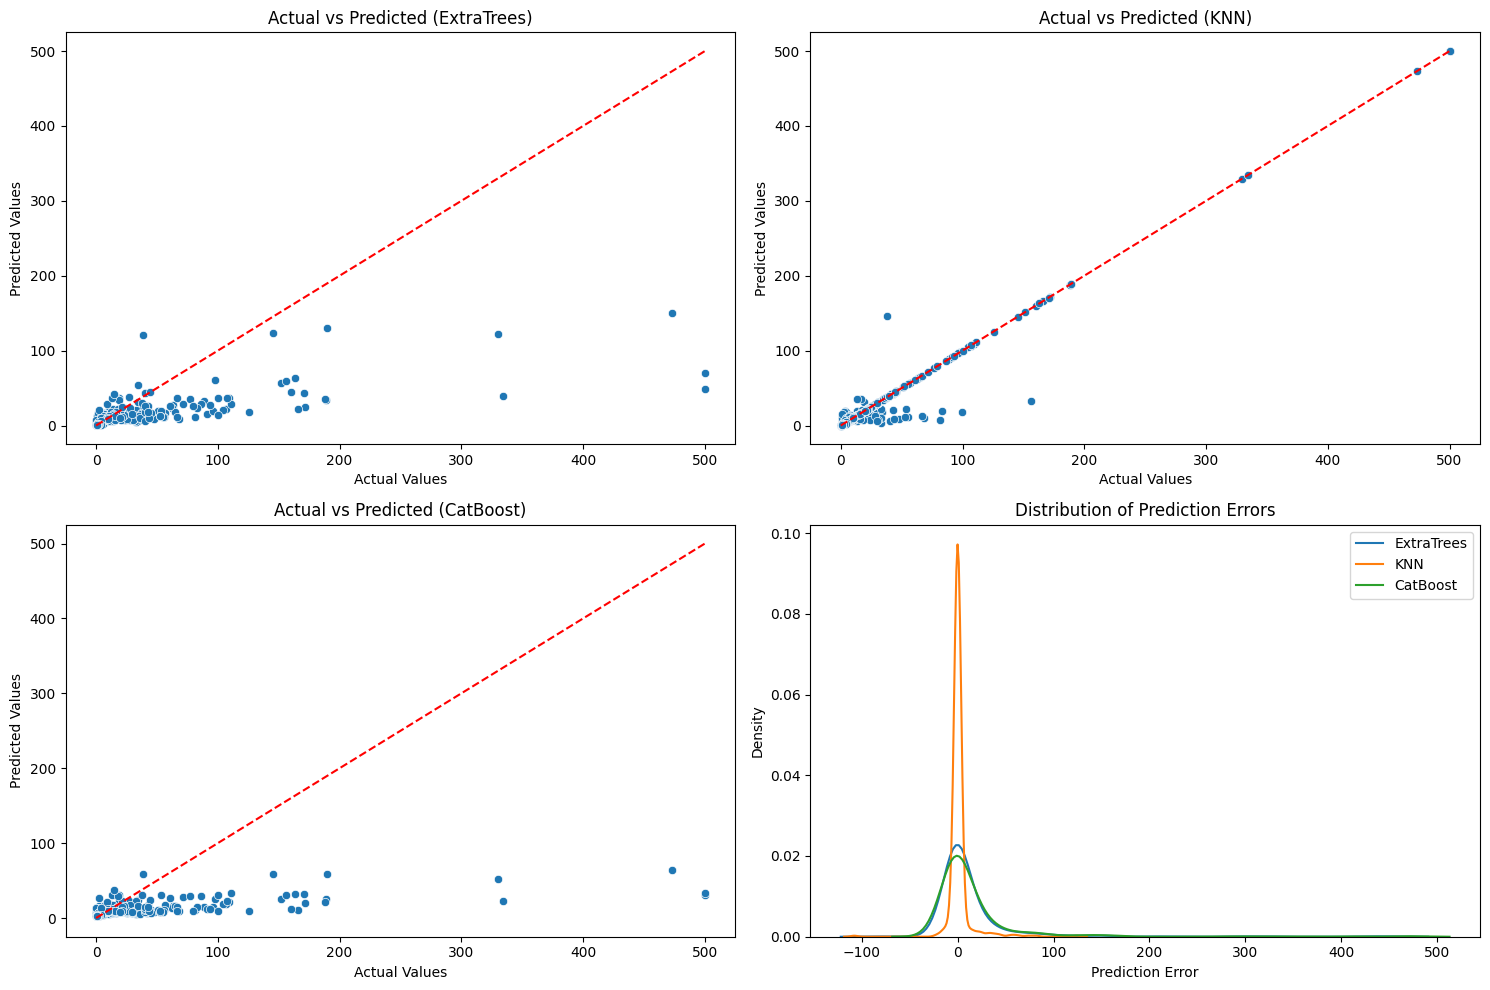

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_umap_top_3_comparison_plot.png
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_umap_extratrees.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_umap_knn.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_umap_catboost.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_umap_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_umap_extratrees.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_umap_knn.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_umap_catboost.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_umap_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных UMAP (3 параметра)

# Инициализация
evaluator_umap = RegressionModelEvaluator(X4, y4, log_target=True)

# Оценка моделей
results = evaluator_umap.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_umap = results.copy()
results_umap['metod'] = metod_name_4
columns_order = ['metod'] + [col for col in results.columns]
results_umap = results_umap[columns_order]

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_umap.predict(X4, inverse_transform=True)
predictions_umap = predictions

# Сохраненние результата
results_umap_id = results_umap.reset_index()
results_umap_id.to_csv(os.path.join(data_dir, csv_file_4), index=False)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_umap.save_comparison_results(n=3, prefix=comparison_file_4, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_umap.save_top_models(n=3, prefix=model_file_4 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_umap.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
ExtraTrees,umap,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",1.497743,0.896096,0.946624,0.776159,0.236480,0.238319,2.033570,0.424396,True,"(ExtraTreeRegressor(max_depth=10, min_samples_..."
KNN,umap,"{'kneighborsregressor__n_neighbors': 15, 'knei...",1.463957,0.919104,0.958699,0.763466,0.216877,0.218694,2.221330,0.411418,True,"(StandardScaler(), KNeighborsRegressor(n_neigh..."
CatBoost,umap,"{'depth': 7, 'iterations': 100, 'l2_leaf_reg':...",1.530428,0.937408,0.968198,0.798808,0.201281,0.202440,1.968149,0.453440,True,<catboost.core.CatBoostRegressor object at 0x7...
RandomForest,umap,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1.568437,0.964560,0.982120,0.806007,0.178146,0.181086,2.138147,0.455830,True,"(DecisionTreeRegressor(max_depth=5, max_featur..."
CatBoost_Tweedie,umap,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",1.534973,0.965777,0.982740,0.800922,0.177109,0.188412,2.037338,0.437844,True,<catboost.core.CatBoostRegressor object at 0x7...


# СВОД И ВЫВОДЫ


In [ ]:
# @title Датасет с результатами всех моделей на валидационной выборке
# Список файлов с результатами
result_files = [csv_file_1, csv_file_2, csv_file_3, csv_file_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[1]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test MSE', ascending=True)
combined_results_for_view.head(5)

,Model,metod,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Data_Type
0,ExtraTrees,df_handmade,1.356914,0.805513,0.897503,0.722676,0.313662,0.315341,2.060352,0.403289,True,"ExtraTreesRegressor(max_depth=10, n_estimators...",SI
1,RandomForest,df_handmade,1.328094,0.822708,0.907032,0.729020,0.299011,0.299768,2.326744,0.414137,True,"RandomForestRegressor(max_depth=10, max_featur...",SI
2,CatBoost,df_handmade,1.338206,0.834861,0.913707,0.729315,0.288656,0.288959,2.292730,0.415932,True,<catboost.core.CatBoostRegressor object at 0x7...,SI
3,XGBoost,df_handmade,1.321730,0.837296,0.915039,0.729029,0.286581,0.286672,2.558522,0.395478,True,"XGBRegressor(base_score=None, booster=None, ca...",SI
4,XGBoost_Tweedie,df_handmade,1.437154,0.853267,0.923725,0.713098,0.272973,0.297005,2.176927,0.386863,True,"XGBRegressor(base_score=None, booster=None, ca...",SI


In [ ]:
# @title вытащим гиперпарамаетры выбранной модели
filtered_row = combined_results[(combined_results['Model'] == "KNN") & (combined_results['metod'] == "umap")]
value = filtered_row.iloc[0]['Best Parameters']
value

"{'kneighborsregressor__n_neighbors': 15, 'kneighborsregressor__p': 1, 'kneighborsregressor__weights': 'distance'}"

In [ ]:
# @title Датасет с результатами 12 моделей на всех данных
top3_csv_file_1 = f"{comparison_file_1}top_3_full_metrics.csv"
top3_csv_file_2 = f"{comparison_file_2}top_3_full_metrics.csv"
top3_csv_file_3 = f"{comparison_file_3}top_3_full_metrics.csv"
top3_csv_file_4 = f"{comparison_file_4}top_3_full_metrics.csv"

# Список файлов с результатами
result_files = [top3_csv_file_1, top3_csv_file_2, top3_csv_file_3, top3_csv_file_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[3]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
final_results = pd.concat(dfs, ignore_index=False)

# Выводим первые строки для проверки
final_results_for_view = final_results.sort_values(by='Full Dataset MSE', ascending=True)
final_results_for_view.head(5)

,Model,Full Dataset MSE,Full Dataset RMSE,Full Dataset MAE,Full Dataset R2,Full Dataset MAPE,Data_Type
0,KNN,146.140283,12.088850,3.582846,0.950587,0.550644,tsne
1,KNN,149.237701,12.216288,3.035796,0.949539,0.263841,umap
0,ExtraTrees,784.904077,28.016140,10.191054,0.734607,3.273803,df
2,ExtraTrees,959.851501,30.981470,9.274692,0.675453,3.065015,pca
1,CatBoost,1222.527640,34.964663,12.080851,0.586636,3.312463,pca


In [ ]:
final_results

,Model,Full Dataset MSE,Full Dataset RMSE,Full Dataset MAE,Full Dataset R2,Full Dataset MAPE,Data_Type
0,ExtraTrees,784.904077,28.016140,10.191054,0.734607,3.273803,df
1,RandomForest,1456.677747,38.166448,13.540256,0.507465,3.255723,df
2,CatBoost,1331.698211,36.492440,12.716113,0.549723,3.446490,df
0,RandomForest,1507.541699,38.827074,13.262731,0.490267,3.270419,pca
1,CatBoost,1222.527640,34.964663,12.080851,0.586636,3.312463,pca
2,ExtraTrees,959.851501,30.981470,9.274692,0.675453,3.065015,pca
0,KNN,146.140283,12.088850,3.582846,0.950587,0.550644,tsne
1,ExtraTrees,2074.787705,45.549838,15.878053,0.298469,2.351912,tsne
2,CatBoost,2162.331203,46.500873,16.602461,0.268868,2.806676,tsne
0,ExtraTrees,2120.971645,46.054008,16.548769,0.282853,2.835093,umap


In [ ]:
# @title ШПАРГАЛКА с гиперпараметрами базовых
""" models_config = {
    # Линейные модели с регуляризацией: Ridge, Lasso, ElasticNet
    'Ridge': {
        'model': make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=2, include_bias=False),
            Ridge()
        ),
        'params': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Lasso': {
        'model': make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=2, include_bias=False),
            Lasso()
        ),
        'params': {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
    },
    'ElasticNet': {
        'model': make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=2, include_bias=False),
            ElasticNet()
        ),
        'params': {
            'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1],
            'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
        }
    },
    # Метод опорных векторов (SVR)
    'SVR': {
        'model': make_pipeline(
            StandardScaler(),
            SVR()
        ),
        'params': {
            'svr__kernel': ['linear', 'rbf', 'poly'],
            'svr__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'svr__epsilon': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
        }
    },
    # Метод k-ближайших соседей (KNN)
    'KNN': {
        'model': make_pipeline(
            StandardScaler(),
            KNeighborsRegressor()
        ),
        'params': {
            'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
            'kneighborsregressor__weights': ['uniform', 'distance'],
            'kneighborsregressor__p': [1, 2]
        }
    },
    # модели деревьев
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=self.random_state),
        'params': {
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(random_state=self.random_state),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=self.random_state),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', 0.8]
        }
    },
    # Бустеры
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=self.random_state),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5]
        }
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingRegressor(random_state=self.random_state),
        'params': {
            'max_iter': [100, 200, 300, 400],
            'learning_rate': [0.05, 0.1],
            'max_depth': [None, 5, 10],
            'min_samples_leaf': [10, 20]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=self.random_state),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=self.random_state, silent=True),
        'params': {
            'iterations': [100, 200, 300, 400],
            'learning_rate': [0.05, 0.1],
            'depth': [3, 5, 7],
            'l2_leaf_reg': [3, 5, 7]
        }
    },
    # МОДЕЛИ ДЛЯ ГАММА-РАСПРЕДЕЛЕНИЯ
    #'GLM_Gamma': {
    #    'model': make_pipeline(
    #        StandardScaler(),
    #        TweedieRegressor(power=2, link='log', max_iter=1000)
    #    ),
    #   'params': {
    #       'tweedieregressor__alpha': [0.001, 0.01, 0.1, 1],
    #       'tweedieregressor__max_iter': [1000]
    #   }
    #},
    'XGBoost_Tweedie': {
        'model': XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.9, random_state=self.random_state),
        'params': {
            'n_estimators': [200, 300],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'CatBoost_Tweedie': {
        'model': CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=self.random_state, silent=True),
        'params': {
            'iterations': [200, 300],
            'learning_rate': [0.05, 0.1],
            'depth': [3, 5, 7],
            'l2_leaf_reg': [3, 5, 7]
        }
    }
}

evaluator = RegressionModelEvaluator(X1, y1, models_config=my_models_config)
results = evaluator.evaluate_models()"""

KNN Test MSE: 0.940
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_final_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_final_top_3_full_metrics.csv


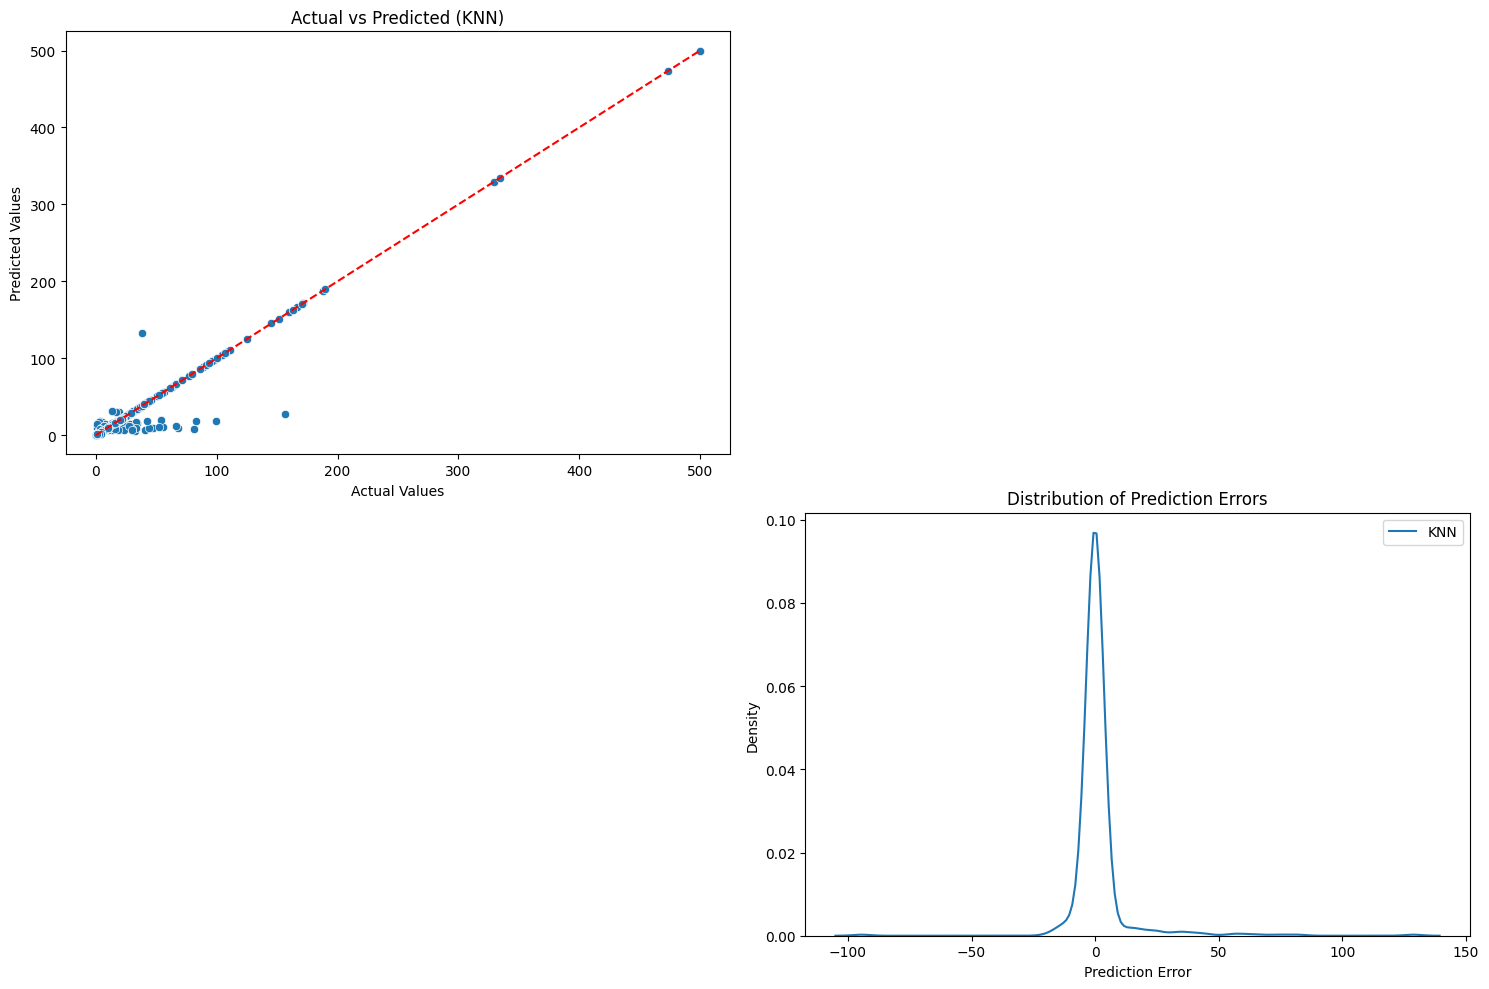

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_SI_regres_final_top_3_comparison_plot.png
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_final_knn.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_final_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_final_knn.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_SI_regres_final_top_3_models_metrics.csv'}

In [ ]:
# @title ТЮНИНГ ТОП 3 МОДЕЛЕЙ
random_state=42

# конструктор имен файлов для сохранения
base_name_final_top3 = f"{base_parameter}_{analyse_name}_final"
csv_file_final_top3 = f"results_{base_name_final_top3}.csv"
comparison_file_final_top3 = f"comparison_{base_name_final_top3}_"
model_file_final_top3 = f"model_{base_name_final_top3}_"

# модели и гиперпараметры
models_config_final_top3 = {
    'KNN': {
        'model': make_pipeline(
            StandardScaler(),
            KNeighborsRegressor()
        ),
        'params': {
            'kneighborsregressor__n_neighbors': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
            'kneighborsregressor__weights': ['uniform', 'distance'],
            'kneighborsregressor__p': [1, 2]
        }
    }
}
# инициализация
evaluator_top3 = RegressionModelEvaluator(X4, y4, log_target=True, models_config=models_config_final_top3, metod_name=metod_name_4) # ПОМЕНЯТЬ ТУТ!

# оценка моделей
results = evaluator_top3.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_handmade = results.copy()
results_handmade['metod'] = metod_name_4 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_top3 = results_handmade[columns_order]

# предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_top3.predict(X4, inverse_transform=True) # ПОМЕНЯТЬ ТУТ!
predictions_top3 = predictions

# сохраненние общего результата
results_top3_id = results_top3.reset_index()
results_top3_id.to_csv(os.path.join(data_dir, csv_file_final_top3), index=False) # ПОМЕНЯТЬ ТУТ!

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_top3.save_comparison_results(n=3, prefix=comparison_file_final_top3, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_top3.save_top_models(n=3, prefix=model_file_final_top3 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!


In [ ]:
file_path = os.path.join(data_dir, 'comparison_SI_regres_final_top_3_full_metrics.csv')
df = pd.read_csv(file_path)
df

,Model,Full Dataset MSE,Full Dataset RMSE,Full Dataset MAE,Full Dataset R2,Full Dataset MAPE
0,KNN,146.143752,12.088993,3.03394,0.950586,0.271595


In [ ]:
results_top3_id
value = results_top3_id.iloc[0]['Best Parameters']
value

{'kneighborsregressor__n_neighbors': 29,
 'kneighborsregressor__p': 2,
 'kneighborsregressor__weights': 'distance'}